<a href="https://colab.research.google.com/github/TerMinator-spec/Stock-market-predictor/blob/master/Copy_of_gpu_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
%cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense, merge, Flatten
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.relative_strength_index import relative_strength_index as rsi
from pyti.moving_average_convergence_divergence import moving_average_convergence_divergence as macd
#Used TA-Lib for creating additional features. More on this later.
# from talib.abstract import *
# from talib import MA_Type

In [ ]:
!pip install pyti

In [ ]:
# import tensorflow as tf
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [ ]:
def resample_stock_data(df, timedelta):
    # make a copy
        df = df.copy()

        # convert index to datetime
        df.index = pd.to_datetime(df.index)

        # sort the index (evidently required by resample())
        df = df.sort_index()

        aggregation_dict = {
             'open': 'first', 
             'high': 'max',
             'low': 'min',
             'close': 'last',

        }

        rename_dict = {
            'open': 'open',
            'high': 'high',
            'low': 'low',
            'close': 'close',

        }


        return (df
          .resample(timedelta)
          .agg(aggregation_dict)
          .rename(columns=rename_dict)
        )

In [ ]:
import pandas as pd
import numpy as np
data=pd.read_csv('bankniftyoneminutefinal.csv')

In [ ]:
data['date_time']=pd.to_datetime(data['date'] + ' ' + data['time'])

In [ ]:
data=data.drop('Unnamed: 6',axis=1)

In [ ]:
data=data.set_index('date_time')

In [ ]:
data_10=resample_stock_data(data,'10min')

In [ ]:
data_10=data_10.dropna()

In [ ]:
data_10.head()

,open,high,low,close
date_time,,,,
2015-01-09 09:10:00,18845.90,18864.00,18790.2,18849.25
2015-01-09 09:20:00,18849.25,18859.65,18799.4,18815.15
2015-01-09 09:30:00,18815.15,18821.40,18772.9,18800.05
2015-01-09 09:40:00,18800.05,18814.25,18758.5,18779.40
2015-01-09 09:50:00,18783.05,18808.30,18761.1,18802.90


In [ ]:
DATA=data_10

In [ ]:
DATA['hour'] = DATA.index.hour
DATA['day']  = DATA.index.weekday
DATA['week'] = DATA.index.week

DATA['close']  = pd.to_numeric(DATA['close'])
DATA['open']   = pd.to_numeric(DATA['open'])

DATA['avg_price']  = (DATA['low'] + DATA['high'])/2
DATA['range']      = DATA['high'] - DATA['low']
DATA['ohlc_price'] = (DATA['low'] + DATA['high'] + DATA['open'] + DATA['close'])/4
DATA['oc_diff']      = DATA['open'] - DATA['close']
DATA['RSI'] = rsi(DATA['close'],  14)
DATA['MACD'] = macd(DATA['close'], 12, 26)

# inputs = {
#     'open'   : DATA['open'].values,
#     'high'   : DATA['high'].values,
#     'low'    : DATA['low'].values,
#     'close'  : DATA['close'].values,
    
# }
DATA['ema'] = ema(DATA["close"], 15)
#DATA['ema'] = MA(inputs, timeperiod=15, matype=MA_Type.T3)
DATA['bear_power'] = DATA['low'] - DATA['ema']
DATA['bull_power'] = DATA['high'] - DATA['ema']
# Since computing EMA leave some of the rows empty, we want to remove them. (EMA is a lagging indicator)
DATA.dropna(inplace=True)
# Add 1D PCA vector as a feature as well. This helped increasing the accuracy by adding more variance to the feature set
pca_input = DATA.drop('close',1).copy()
pca_features = pca_input.columns.tolist()
pca = PCA(n_components=1)
DATA['pca'] = pca.fit_transform(pca_input.values.astype('float32'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
DATA.head()

,open,high,low,close,hour,day,week,avg_price,range,ohlc_price,oc_diff,RSI,MACD,ema,bear_power,bull_power,pca
date_time,,,,,,,,,,,,,,,,,
2015-01-09 13:20:00,18597.30,18606.10,18570.30,18600.15,13,4,2,18588.200,35.80,18593.4625,-2.85,35.446717,-57.375399,18621.286213,-50.986213,-15.186213,-10850.140625
2015-01-09 13:30:00,18600.15,18605.85,18568.80,18588.25,13,4,2,18587.325,37.05,18590.7625,11.90,34.374929,-54.296261,18613.478461,-44.678461,-7.628461,-10854.420898
2015-01-09 13:40:00,18590.00,18597.50,18571.30,18582.35,13,4,2,18584.400,26.20,18585.2875,7.65,33.828783,-52.099189,18606.025190,-34.725190,-8.525190,-10867.429688
2015-01-09 13:50:00,18578.00,18592.00,18493.80,18519.10,13,4,2,18542.900,98.20,18545.7250,58.90,28.585470,-55.830937,18590.966579,-97.166579,1.033421,-10945.403320
2015-01-09 14:00:00,18519.10,18529.30,18479.65,18521.25,14,4,2,18504.475,49.65,18512.3250,-2.15,28.988383,-55.531696,18578.798979,-99.148979,-49.498979,-11035.163086


In [ ]:
dates=DATA.index

In [ ]:
dates

DatetimeIndex(['2015-01-09 13:20:00', '2015-01-09 13:30:00',
               '2015-01-09 13:40:00', '2015-01-09 13:50:00',
               '2015-01-09 14:00:00', '2015-01-09 14:10:00',
               '2015-01-09 14:20:00', '2015-01-09 14:30:00',
               '2015-01-09 14:40:00', '2015-01-09 14:50:00',
               ...
               '2020-11-27 13:50:00', '2020-11-27 14:00:00',
               '2020-11-27 14:10:00', '2020-11-27 14:20:00',
               '2020-11-27 14:30:00', '2020-11-27 14:40:00',
               '2020-11-27 14:50:00', '2020-11-27 15:00:00',
               '2020-11-27 15:10:00', '2020-11-27 15:20:00'],
              dtype='datetime64[ns]', name='date_time', length=55075, freq=None)

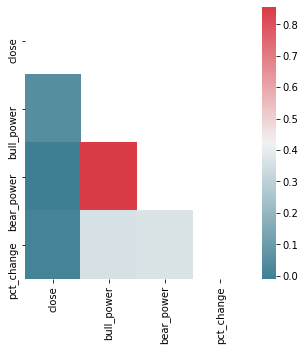

In [ ]:
t = DATA[['close', 'bull_power', 'bear_power']].copy()
t['pct_change'] = t['close'].pct_change()
t.dropna(inplace=True)
corr =  t.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax=ax)

In [ ]:
def create_dataset(dataset, look_back=10):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [ ]:
#TARGET     = 'USD_CAD'
#granuality = 'H1'
LOOK_BACK  = 20
SPLIT      = 0.80     # data split ration for training and testing

In [ ]:
# Create scalers
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(DATA), columns=DATA.columns)
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler = x_scaler.fit(DATA.drop('high', axis=1).values.astype('float32'))
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = y_scaler.fit(DATA['high'].values.astype('float32').reshape(-1,1))


In [ ]:
y_scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled.columns.tolist().index('high')

2

In [ ]:
# Create dataset
target_index = scaled.columns.tolist().index('high')
dataset = scaled.values.astype('float32')
X, y = create_dataset(dataset, look_back=LOOK_BACK)
y = y[:,target_index]
train_size = int(len(X) * SPLIT)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

In [ ]:
testX.shape

(11011, 20, 17)

In [ ]:
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
#model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(4, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='random_uniform', activation='relu'))

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(4, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='random_uniform', activation='relu'))

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard as tensorboard

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

In [ ]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
# Enable this line if you want to monitor the trianing progress via TensorBoard
# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=100, batch_size=500, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
80/80 [==============================] - 14s 99ms/step - loss: 0.2051 - mae: 0.3969 - mse: 0.2051 - val_loss: 0.2841 - val_mae: 0.5281 - val_mse: 0.2841
Epoch 2/100
80/80 [==============================] - 7s 82ms/step - loss: 0.0491 - mae: 0.1961 - mse: 0.0491 - val_loss: 0.1794 - val_mae: 0.4173 - val_mse: 0.1794
Epoch 3/100
80/80 [==============================] - 6s 80ms/step - loss: 0.0372 - mae: 0.1659 - mse: 0.0372 - val_loss: 0.0304 - val_mae: 0.1593 - val_mse: 0.0304
Epoch 4/100
80/80 [==============================] - 6s 78ms/step - loss: 7.9765e-04 - mae: 0.0168 - mse: 7.9765e-04 - val_loss: 0.0132 - val_mae: 0.0953 - val_mse: 0.0132
Epoch 5/100
80/80 [==============================] - 6s 80ms/step - loss: 3.2959e-04 - mae: 0.0111 - mse: 3.2959e-04 - val_loss: 0.0084 - val_mae: 0.0734 - val_mse: 0.0084
Epoch 6/100
80/80 [==============================] - 6s 79ms/step - loss: 2.3101e-04 - mae: 0.0099 - mse: 2.3101e-04 - val_loss: 0.0055 - val_mae: 0.0578 - val_mse

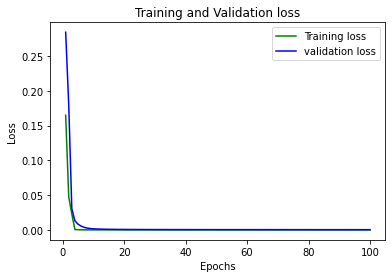

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%10==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, lr_decay]
history = model.fit(trainX, trainY, epochs=100, batch_size=500, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
90/90 [==============================] - 8s 88ms/step - mae: 0.3448 - loss: 0.1740 - mse: 0.1740 - val_loss: 0.2023 - val_mse: 0.2023 - val_mae: 0.4055
Epoch 2/100
90/90 [==============================] - 7s 81ms/step - mae: 0.2190 - loss: 0.0587 - mse: 0.0587 - val_loss: 0.1557 - val_mse: 0.1557 - val_mae: 0.3670
Epoch 3/100
90/90 [==============================] - 8s 84ms/step - mae: 0.2189 - loss: 0.0583 - mse: 0.0583 - val_loss: 0.1534 - val_mse: 0.1534 - val_mae: 0.3649
Epoch 4/100
90/90 [==============================] - 8s 84ms/step - mae: 0.2189 - loss: 0.0583 - mse: 0.0583 - val_loss: 0.1541 - val_mse: 0.1541 - val_mae: 0.3655
Epoch 5/100
90/90 [==============================] - 7s 78ms/step - mae: 0.0836 - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0896
Epoch 6/100
90/90 [==============================] - 7s 77ms/step - mae: 0.0139 - loss: 4.3998e-04 - mse: 4.3998e-04 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0481
Epoch 7/

90/90 [==============================] - 7s 82ms/step - mae: 0.0064 - loss: 9.3163e-05 - mse: 9.3163e-05 - val_loss: 5.1147e-04 - val_mse: 5.1147e-04 - val_mae: 0.0161
Epoch 24/100
90/90 [==============================] - 7s 82ms/step - mae: 0.0062 - loss: 8.7347e-05 - mse: 8.7347e-05 - val_loss: 4.9690e-04 - val_mse: 4.9690e-04 - val_mae: 0.0162
Epoch 25/100
90/90 [==============================] - 7s 82ms/step - mae: 0.0062 - loss: 8.6961e-05 - mse: 8.6961e-05 - val_loss: 4.8745e-04 - val_mse: 4.8745e-04 - val_mae: 0.0158
Epoch 26/100
90/90 [==============================] - 8s 88ms/step - mae: 0.0060 - loss: 8.1666e-05 - mse: 8.1666e-05 - val_loss: 4.7070e-04 - val_mse: 4.7070e-04 - val_mae: 0.0154
Epoch 27/100
90/90 [==============================] - 8s 89ms/step - mae: 0.0058 - loss: 7.7367e-05 - mse: 7.7367e-05 - val_loss: 4.8025e-04 - val_mse: 4.8025e-04 - val_mae: 0.0159
Epoch 28/100
90/90 [==============================] - 8s 89ms/step - mae: 0.0060 - loss: 7.9860e-05 - mse: 7

Epoch 45/100
90/90 [==============================] - 8s 87ms/step - mae: 0.0047 - loss: 4.4715e-05 - mse: 4.4715e-05 - val_loss: 3.1578e-04 - val_mse: 3.1578e-04 - val_mae: 0.0121
Epoch 46/100
90/90 [==============================] - 7s 80ms/step - mae: 0.0045 - loss: 4.1760e-05 - mse: 4.1760e-05 - val_loss: 3.0858e-04 - val_mse: 3.0858e-04 - val_mae: 0.0119
Epoch 47/100
90/90 [==============================] - 7s 80ms/step - mae: 0.0046 - loss: 4.2167e-05 - mse: 4.2167e-05 - val_loss: 3.0731e-04 - val_mse: 3.0731e-04 - val_mae: 0.0119
Epoch 48/100
90/90 [==============================] - 7s 77ms/step - mae: 0.0046 - loss: 4.1749e-05 - mse: 4.1749e-05 - val_loss: 3.0955e-04 - val_mse: 3.0955e-04 - val_mae: 0.0120
Epoch 49/100
90/90 [==============================] - 7s 78ms/step - mae: 0.0044 - loss: 3.8821e-05 - mse: 3.8821e-05 - val_loss: 2.9854e-04 - val_mse: 2.9854e-04 - val_mae: 0.0117
Epoch 50/100
90/90 [==============================] - 8s 92ms/step - mae: 0.0045 - loss: 4.0089

90/90 [==============================] - 7s 81ms/step - mae: 0.0039 - loss: 2.8543e-05 - mse: 2.8543e-05 - val_loss: 2.6766e-04 - val_mse: 2.6766e-04 - val_mae: 0.0115
Epoch 67/100
90/90 [==============================] - 7s 79ms/step - mae: 0.0039 - loss: 2.7806e-05 - mse: 2.7806e-05 - val_loss: 2.4828e-04 - val_mse: 2.4828e-04 - val_mae: 0.0106
Epoch 68/100
90/90 [==============================] - 8s 85ms/step - mae: 0.0039 - loss: 2.8083e-05 - mse: 2.8083e-05 - val_loss: 2.4995e-04 - val_mse: 2.4995e-04 - val_mae: 0.0107
Epoch 69/100
90/90 [==============================] - 8s 85ms/step - mae: 0.0041 - loss: 3.0142e-05 - mse: 3.0142e-05 - val_loss: 2.4947e-04 - val_mse: 2.4947e-04 - val_mae: 0.0105
Epoch 70/100
90/90 [==============================] - 8s 91ms/step - mae: 0.0038 - loss: 2.6469e-05 - mse: 2.6469e-05 - val_loss: 2.4045e-04 - val_mse: 2.4045e-04 - val_mae: 0.0103
lr changed to 0.00047829695977270604
Epoch 71/100
90/90 [==============================] - 8s 90ms/step - ma

90/90 [==============================] - 7s 80ms/step - mae: 0.0034 - loss: 2.0847e-05 - mse: 2.0847e-05 - val_loss: 2.0686e-04 - val_mse: 2.0686e-04 - val_mae: 0.0092
Epoch 89/100
90/90 [==============================] - 7s 81ms/step - mae: 0.0034 - loss: 2.0786e-05 - mse: 2.0786e-05 - val_loss: 2.1533e-04 - val_mse: 2.1533e-04 - val_mae: 0.0094
Epoch 90/100
90/90 [==============================] - 7s 83ms/step - mae: 0.0033 - loss: 2.0070e-05 - mse: 2.0070e-05 - val_loss: 2.1011e-04 - val_mse: 2.1011e-04 - val_mae: 0.0098
lr changed to 0.00038742052274756136
Epoch 91/100
90/90 [==============================] - 7s 79ms/step - mae: 0.0033 - loss: 1.9953e-05 - mse: 1.9953e-05 - val_loss: 2.0231e-04 - val_mse: 2.0231e-04 - val_mae: 0.0092
Epoch 92/100
90/90 [==============================] - 7s 80ms/step - mae: 0.0033 - loss: 2.0338e-05 - mse: 2.0338e-05 - val_loss: 1.9573e-04 - val_mse: 1.9573e-04 - val_mae: 0.0091
Epoch 93/100
90/90 [==============================] - 8s 87ms/step - ma

In [ ]:
pred=model.predict(testX)

In [ ]:
test2=y_scaler.inverse_transform(testY.reshape(-1,1))

In [ ]:
pred2=y_scaler.inverse_transform(pred.reshape(-1,1))

In [ ]:
pred2

array([[19292.383],
       [19248.344],
       [19274.38 ],
       ...,
       [29605.65 ],
       [29597.336],
       [29622.723]], dtype=float32)

In [ ]:
test2

array([[19055.8  ],
       [19453.25 ],
       [19483.049],
       ...,
       [29586.6  ],
       [29644.15 ],
       [29643.049]], dtype=float32)

In [ ]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(test2,pred2)

In [ ]:
mse

NameError: ignored

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
def create_model(dropout_rate=0.0, optimizer="adam"):
  model = Sequential()
  model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
  model.add(LSTM(20, return_sequences=True))
  #model.add(LSTM(10, return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(10, return_sequences=False))
  model.add(Dense(4, kernel_initializer='random_uniform', activation='relu'))
  model.add(Dense(1, kernel_initializer='random_uniform', activation='relu'))
  model.compile(optimizer = optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
  return model

In [ ]:
seed = 7
np.random.seed(seed)
model = KerasRegressor(build_fn=create_model, verbose=0)

In [ ]:
batch_size = [ 25, 100, 300]
epochs = [20, 40, 90]
optimizer = ['SGD', 'RMSprop', 'Adam']
dropout_rate = [0.2, 0.3, 0.4]

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(trainX, trainY)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

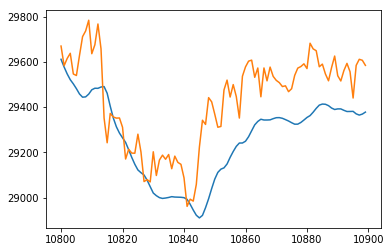

In [ ]:
plt.plot(df[-100:])

In [ ]:
regressor.save('my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model\assets


In [ ]:
model.save("model.h5")

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('model.h5')

In [ ]:
pred=model.predict(X_test)

In [ ]:
len(y_test_dates[120:])

10900

In [ ]:
dicts={"test":list(test2.reshape(len(test2),)), 'pred': list(pred2.reshape(len(pred2),))}

In [ ]:
df=pd.DataFrame(dicts)

In [ ]:
df.head(60)

,test,pred
0,29211.650391,29967.412109
1,29282.748047,29895.167969
2,29262.500000,29818.068359
3,29240.498047,29734.003906
4,29223.000000,29655.375000
5,29177.898438,29578.054688
6,29198.699219,29508.037109
7,29273.400391,29447.232422
8,29248.548828,29408.281250
9,29205.597656,29376.982422


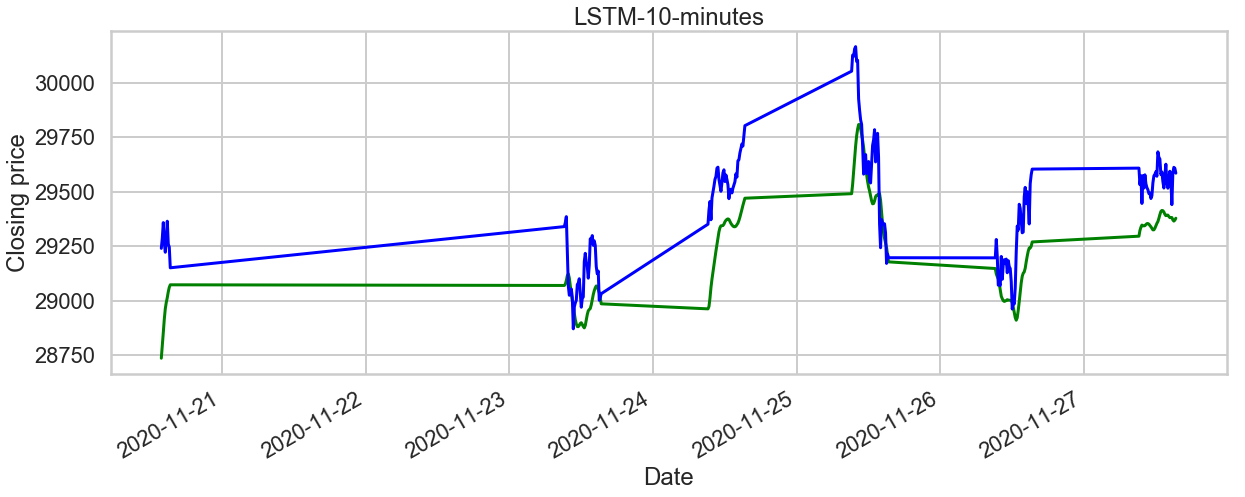

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
fig = plt.figure(figsize = (20,7))

sns.lineplot(x = "date", y = "pred", data=df[-200:],
             palette = "hot"
             ,color="green"
            )
sns.lineplot(x = "date", y = "test", data=df[-200:],
             palette = "hot"
             ,color="blue"
            )

fig.autofmt_xdate()

plt.title("LSTM-10-minutes") # for title
plt.xlabel("Date") # label for x-axis
plt.ylabel("Closing price") # label for y-axis
plt.show()

In [ ]:
df['pred_lag']=df['pred'].shift(1)

In [ ]:
df['test_lag']=df['test'].shift(1)

In [ ]:
df=df.dropna()

In [ ]:
r=0

In [ ]:
df['position'] = np.where(df['pred']> (1+r)*df['pred_lag'], 1, 0) 

In [ ]:
df['position_act']= np.where(df['test']> (1+r)*df['test_lag'], 1, 0) 

In [ ]:
df.head(60)

,test,pred,pred_lag,test_lag,position,position_act,returns
2,29262.500000,29818.068359,29895.167969,29282.748047,0,0,-0.000691
3,29240.498047,29734.003906,29818.068359,29262.500000,0,0,-0.000752
4,29223.000000,29655.375000,29734.003906,29240.498047,0,0,-0.000598
5,29177.898438,29578.054688,29655.375000,29223.000000,0,0,-0.001543
6,29198.699219,29508.037109,29578.054688,29177.898438,0,1,0.000713
7,29273.400391,29447.232422,29508.037109,29198.699219,0,1,0.002558
8,29248.548828,29408.281250,29447.232422,29273.400391,0,0,-0.000849
9,29205.597656,29376.982422,29408.281250,29248.548828,0,0,-0.001468
10,29200.550781,29356.707031,29376.982422,29205.597656,0,0,-0.000173
11,29116.798828,29353.248047,29356.707031,29200.550781,0,0,-0.002868


In [ ]:
df['returns']=df['test'].pct_change()

In [ ]:
df=df.dropna()

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(df['position_act'],df['position'])

0.5510445049954587

In [ ]:
df["strategy"] = df["position"] * df["returns"]
df.dropna(inplace=True)
df["creturns"] = (1+df["returns"]).cumprod()-1
df["cstrategy"] = (1+df["strategy"]).cumprod()-1

# absolute performance of the strategy
perf = df["cstrategy"].iloc[-1]

In [ ]:
df["creturns"].iloc[-1]

0.012304199751778988

In [ ]:
perf

6.32220009520673